# Clustering workshop

Welcome to the workshop for Clustering!

In this notebook we're going to work with several clustering algorithms from Scikit-Learn library, namely:
* KMeans
* GMM
* Agglomerative (hierarchical) clustering
* DBSCAN

We'll also take a look at some ways to estimate clustering quality and choose the number of clusters.

We'll use the data about different sorts of red wine from `sklearn.datasets` module.

# All imports necessary

It is a good practice to have all imports in one place.

In [321]:
! pip install plotly --upgrade

In [322]:
import numpy as np
import pandas as pd

import itertools

from tqdm.notebook import tqdm as tqdm

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import plotly.express as px
import plotly
print(f"plotly.__version__: {plotly.__version__}")

from scipy.spatial.distance import cdist
from sklearn.datasets import load_wine, make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, \
  silhouette_score, silhouette_samples, v_measure_score

plotly.__version__: 5.18.0


In [323]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.facecolor'] = 'white'

plt.style.use('seaborn-v0_8-white')

# Auxiliary methods

Better way would be to have some separate modules with this functionality, because it can be tested separately, but when working with exploratory tasks there might be not enough time to concentrate on these things.

Yet it still makes sense to separate some methods, just to avoid redundant code duplication.

In [324]:
def plot_heatmap(y_predicted, y_true, y_predicted_labels, y_true_labels):
    fig = px.imshow(
        pd.crosstab(y_predicted, y_true, rownames=['y_ground_truth'], colnames=['y_predicted']).values,
        labels=dict(x="Predicted", y="Ground truth", color="Count of matches"),
        x=y_predicted_labels,
        y=y_true_labels
    )
    fig.update_layout(title='Clustering results')
    fig.update_xaxes(side="top")
    fig.show()

In [325]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
  labels = kmeans.fit_predict(X)
  ax = ax or plt.gca()
  ax.axis('equal')
  ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
  centers = kmeans.cluster_centers_
  radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
  for c, r in zip(centers, radii):
    ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [326]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
  ax = ax or plt.gca()
  if covariance.shape == (2, 2):
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
  else:
    angle = 0
    width, height = 2 * np.sqrt(covariance)
  for nsig in range(1, 4):
    ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
  ax = ax or plt.gca()
  labels = gmm.fit(X).predict(X)
  if label:
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
  else:
    ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
  ax.axis('equal')
  w_factor = 0.2 / gmm.weights_.max()

  for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

In [327]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

# Read the data

Before you go through the cells, you must download the data.

In [328]:
data = load_wine()

In [329]:
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [330]:
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = pd.Series(data=data.target, dtype="category")

In [331]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [332]:
y.describe()

count     178
unique      3
top         1
freq       71
dtype: int64

In [333]:
target_mapping = dict(zip([0, 1, 2], data.target_names))

# Short EDA

In [334]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [335]:
pca = PCA(n_components=2)

X_2d = pca.fit_transform(X_scaled)

In [336]:
X['pca_x'], X['pca_y'], X['ground_truth'] = X_2d[:, 0], X_2d[:, 1], y.map(target_mapping)

In [337]:
fig = px.scatter(X, x='pca_x', y='pca_y', color='ground_truth', hover_data=data.feature_names)
fig.update_layout(title='Red wine sorts in 2d PCA space (Ground truth labels)')
fig.show()

# KMeans

K-means is method of clustering based on inertia criteria.
<p> Lets define inertia as $I = \sum_{i=1}^k \sum_{j=1}^{N_i} ||(x_{c_i} - x_{j}^{(i)})||_2$, where k is count of clusters(hyperparameter), $x_{c_i}$ - cluster centroid, $N_i$
 - size of cluster, $x_{j}^{(i)}$ - element of cluster. Vector norm is $L_2$, but we can change it by any metric we want. <p>
This formula defines cluster variance and K-means tries to minimize it with given number of clusters. The minimun value of this loss is 0 when all samples are located at the same point. <p>
Algorythm of training K-means model is paritcular case of E-M algorithm. <p>

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width="300" height="300">


Drawbacks:

*   Need to select k
*   Decision boundary of cluster is convex so clusters with complex shape cannot be detected
* Depends on initial state as algorythm guarantees only convergence to the local minimum

In [344]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=4, init='k-means++', n_init=10, batch_size=200)

In [345]:
y_minibatch_kmeans = minibatch_kmeans.fit_predict(X_scaled)

In [346]:
minibatch_kmeans_labels_mapping = dict(zip([0, 1, 2], ['label_0', 'label_1', 'label_2']))
#'label_1', 'label_2', 'label_0'
#'label_0', 'label_1', 'label_2'

In [347]:
plot_heatmap(pd.Series(y_minibatch_kmeans).map(minibatch_kmeans_labels_mapping), y.map(target_mapping), ['label_0', 'label_1', 'label_2'], data.target_names)

In [348]:
X['minibatch_kmeans_label'] = pd.Series(y_minibatch_kmeans).map(minibatch_kmeans_labels_mapping)

In [349]:
fig = px.scatter(X, x='pca_x', y='pca_y', color='minibatch_kmeans_label', hover_data=data.feature_names)
fig.update_layout(title='Red wine sorts in 2d PCA space (MiniBatch KMeans labels)')
fig.show()

## Disadvantages of KMeans

K-Means can only handle spherical shapes of clusters

In [350]:
X_test, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X_test = X_test[:, ::-1] # Transpose for convenience

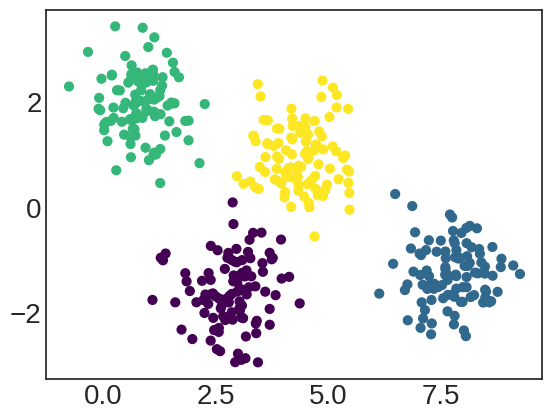

In [351]:
# Plot K-Means
kmeans = KMeans(4, random_state=0, n_init=10)
labels = kmeans.fit(X_test).predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

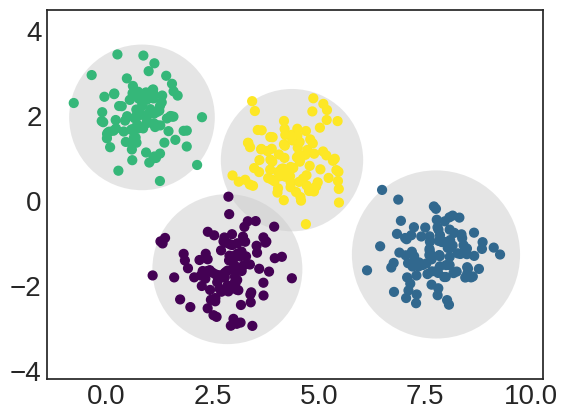

In [352]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
plot_kmeans(kmeans, X_test)

In [353]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X_test, rng.randn(2, 2))

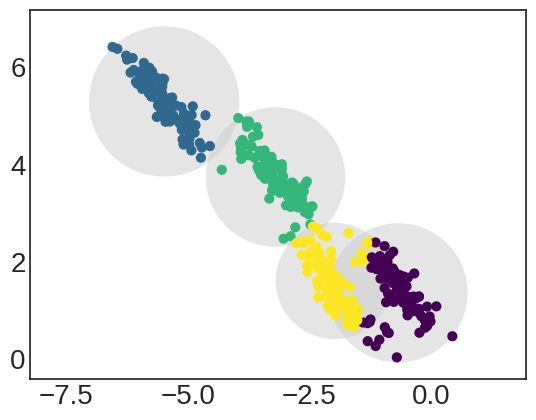

In [354]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
plot_kmeans(kmeans, X_stretched)

# Gaussian Mixture Model

<ipython-input-326-7ee03f51853a>:11: MatplotlibDeprecationWarning:

Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.



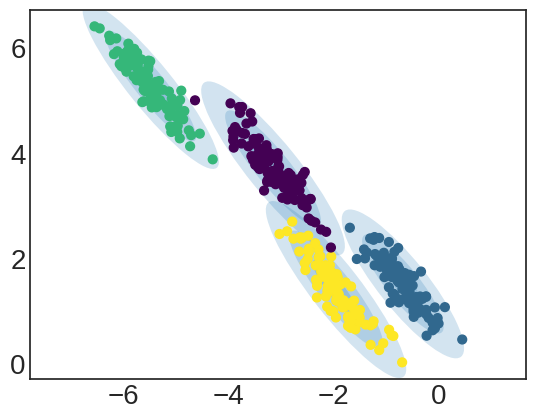

In [355]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

In [356]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=1)
y_gmm = gmm.fit_predict(X_scaled)

In [357]:
gmm_labels_mapping = dict(zip([0, 1, 2], ['label_1', 'label_2', 'label_0']))

In [358]:
plot_heatmap(pd.Series(y_gmm).map(gmm_labels_mapping), y.map(target_mapping), ['label_1', 'label_2', 'label_0'], data.target_names)

In [359]:
X['gmm_label'] = pd.Series(y_gmm).map(gmm_labels_mapping)

In [360]:
fig = px.scatter(X, x='pca_x', y='pca_y', color='gmm_label', hover_data=data.feature_names)
fig.update_layout(title='Red wine sorts in 2d PCA space (GMM clustering labels)')
fig.show()

In [361]:
gmm.fit_predict(X_scaled)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [362]:
gmm.fit(X_scaled)
gmm.predict_proba(X_scaled)[:10]

array([[3.94490851e-14, 1.67123824e-51, 1.00000000e+00],
       [2.77488074e-10, 7.25872422e-46, 1.00000000e+00],
       [9.83155952e-10, 7.24458864e-56, 9.99999999e-01],
       [2.63111853e-23, 1.29629974e-87, 1.00000000e+00],
       [2.21578839e-04, 6.33671138e-24, 9.99778421e-01],
       [7.71709218e-20, 4.97451401e-81, 1.00000000e+00],
       [3.25571259e-18, 1.64240733e-54, 1.00000000e+00],
       [1.82043695e-15, 4.69961220e-51, 1.00000000e+00],
       [3.52129524e-11, 6.31105231e-46, 1.00000000e+00],
       [3.04584244e-12, 4.13648524e-51, 1.00000000e+00]])

# Agglomerative (hierarchical) clustering

Hierarchical clustering constructs a (usually binary) tree over the data. The leaves are individual
data items, while the root is a single cluster that contains all of the data. Between the root and
the leaves are intermediate clusters that contain subsets of the data. The main idea of hierarchical
clustering is to make “clusters of clusters” going upwards to construct a tree. <p>

Hierarchical agglomerative clustering (HAC)
starts at the bottom, with every datum in its own singleton cluster, and merges groups together.
Divisive clustering starts with all of the data in one big group and then chops it up until every
datum is in its own singleton group. <p>

![](https://dashee87.github.io/images/hierarch.gif)

Cluster linkage - dissimilarity between clusters, or cluster distance. There are several types:
* Complete - maximum distance between samples in clusters
* Single - minimum distance between samples in clusters
* Average - mean distance
* Ward - minimizes the variance of clusters being merged

## Build a model with 3 clusters

In [369]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward')

In [370]:
y_agglomerative = agglomerative.fit_predict(X_scaled)

In [371]:
agglomerative_labels_mapping = dict(zip([0, 1, 2], ['label_1', 'label_2', 'label_0']))
# 'label_0', 'label_1', 'label_2'
# 'label_1', 'label_2', 'label_0'

In [372]:
plot_heatmap(pd.Series(y_agglomerative).map(agglomerative_labels_mapping), y.map(target_mapping), ['label_1', 'label_2', 'label_0'], data.target_names)

In [373]:
X['agglomerative_label'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)

In [374]:
fig = px.scatter(X, x='pca_x', y='pca_y', color='agglomerative_label', hover_data=data.feature_names)
fig.update_layout(title='Red wine sorts in 2d PCA space (Agglomerative clustering labels)')
fig.show()

## Plot a dendrogram

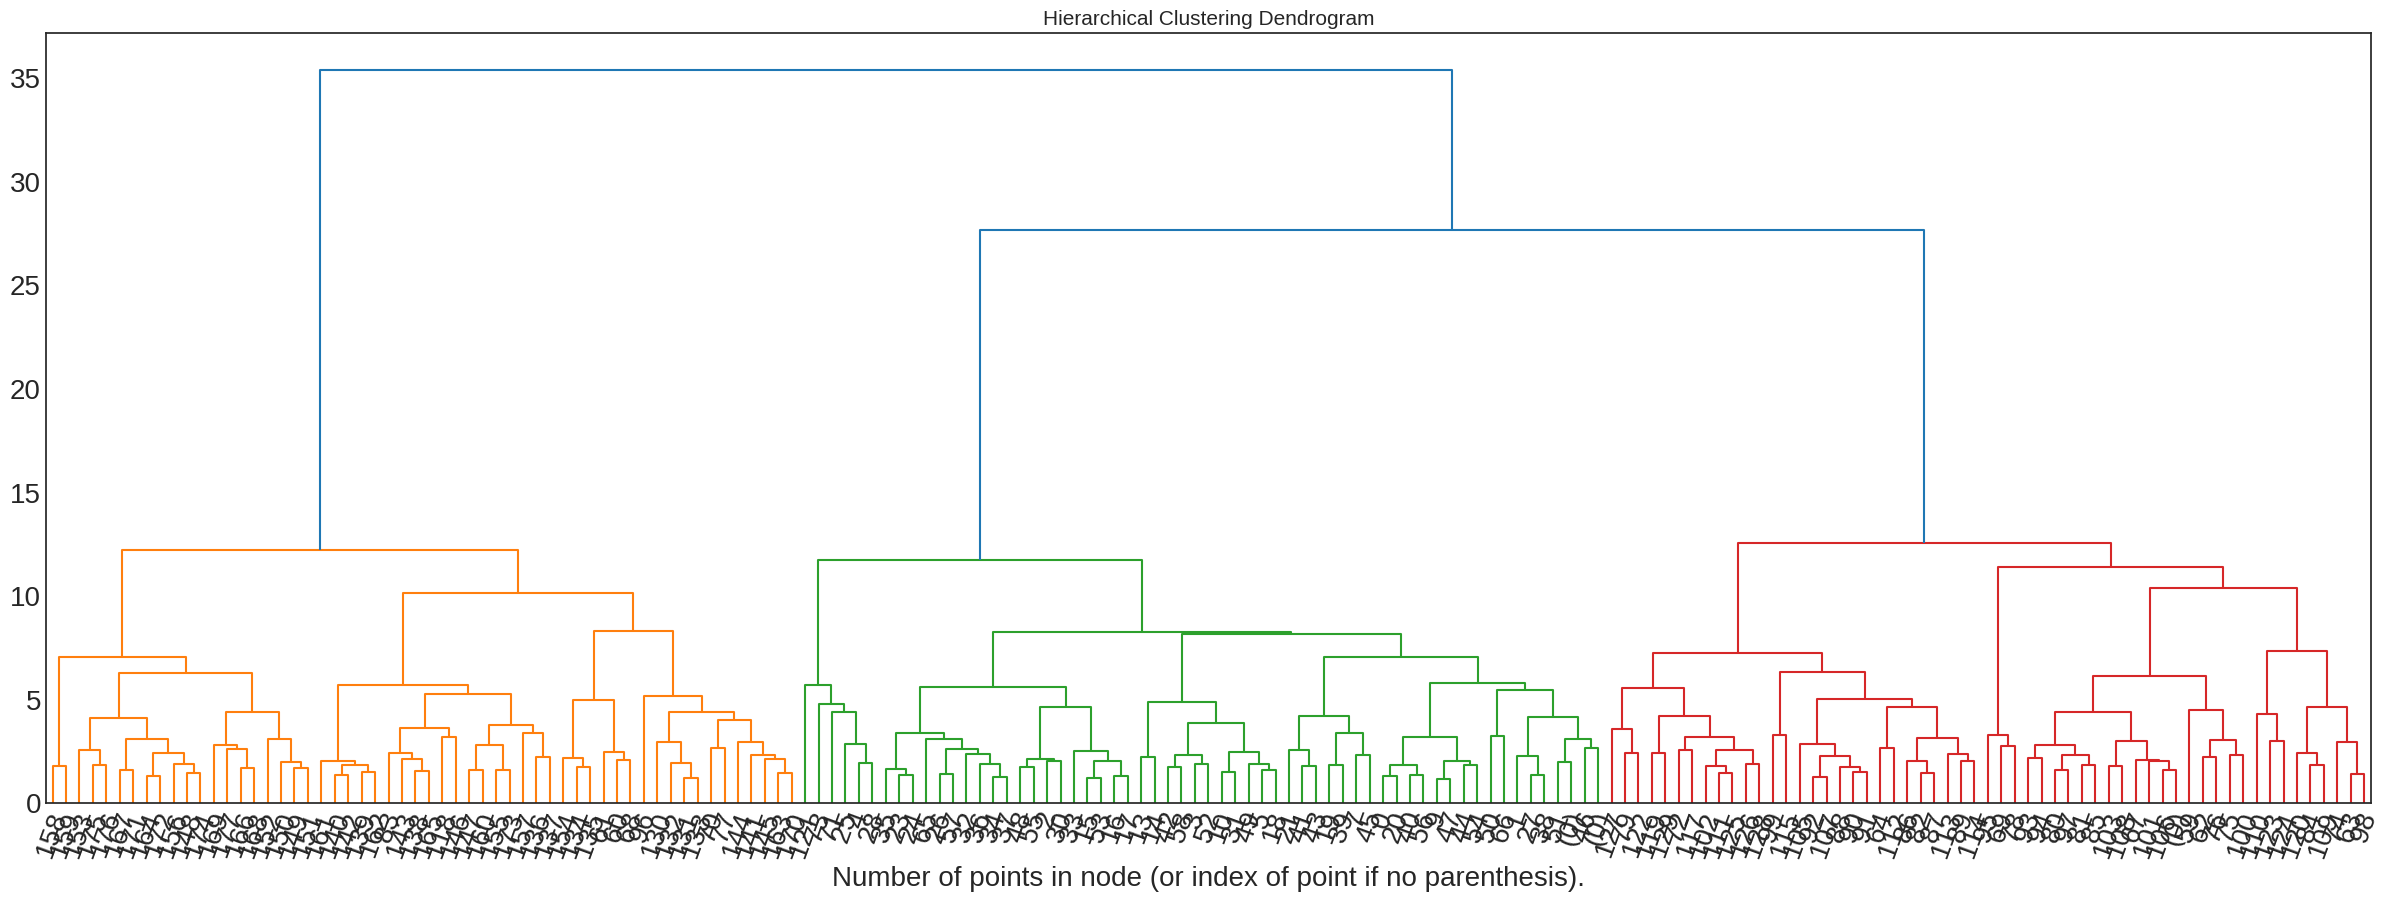

In [378]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_scaled)

plot_dendrogram(model, truncate_mode='level', p=10) # p=3,5,7

# DBSCAN

DBSCAN (Density-based spatial clustering of applications with noise) - density based algorithm of clustering. <p>
Main assumption is that if points are close enough then they can be classified to the same cluster. If point has no close points it is considered as outlier. So DBSCAN can also be used as outlier detection model. <p>

![](https://i.stack.imgur.com/5aikc.png)

Lets define $N_i^{\epsilon} = \{x_j| x_j \in X, \rho (x_i, x_j) < \epsilon, i\neq j\}$ - set of reachable points for $x_i$ with $\epsilon$ distance. <p>

Better if we visualize how it works [demo](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

*   Points with $|N_i^{\epsilon}| > n$ are named core points. If two core points are reachable from each other, they are merged into one cluster.
*   If point is not core and is reachable to some core point, it is assigned to its' cluster. If there are several points the closest core point is choosed.
* If point has no core points in $N_i^{\epsilon}$ than it is assigned to outliers.

$\epsilon$ and $n$ are hyperparameters of this algorythm.

Drawbacks:


*   Have to choose $\epsilon$ and $n$.
*   DBSCAN is a metric based model so we need to normalize features and select correct metric.
*  Clusters with varying density are hard to detect.



## Hyperparameter Tuning

* How to determine **eps**?

We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

The optimal value for epsilon will be found at the point of maximum curvature.


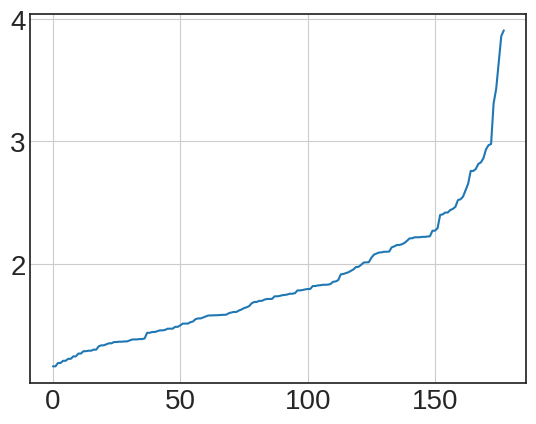

In [379]:
neighbours = NearestNeighbors(n_neighbors=2)
nbrs = neighbours.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

* How to determine **min_samples**?


min_samples (default=5) is selected based on the domain knowledge.

If you do not have domain understanding, a rule of thumb is to derive min_samples from the number of dimensions D in the data set. min_samples >= D + 1. For 2D data, take min_samples = 4.

In [380]:
X_scaled.shape[1]

13

In [381]:
dbscan = DBSCAN(eps=2.3, min_samples=X_scaled.shape[1]+1)

In [382]:
y_dbscan = dbscan.fit_predict(X_scaled)

In [383]:
dbscan_labels_mapping = dict(zip([-1, 0, 1, 2], ['OUTLIER', 'label_0', 'label_1', 'label_2']))

In [384]:
pd.crosstab(
    pd.Series(y_dbscan).map(dbscan_labels_mapping),
    y.map(target_mapping),
    rownames=['y_ground_truth'],
    colnames=['y_predicted']
)

y_predicted,class_0,class_1,class_2
y_ground_truth,,,
OUTLIER,10,52,32
label_0,49,2,0
label_1,0,17,0
label_2,0,0,16


In [385]:
X['dbscan_label'] = pd.Series(y_dbscan).map(dbscan_labels_mapping)

In [386]:
fig = px.scatter(X, x='pca_x', y='pca_y', color='dbscan_label', hover_data=data.feature_names)
fig.update_layout(title='Red wine sorts in 2d PCA space (DBSCAN labels)')
fig.show()

# Clustering quality metrics

Metrics for measuring quality of clustering can be divided into 2 main groups - when we have ground truth labels and when we don't. <p>

For measuring quality with labels we can use mutual information score (MI), adjusted Rand index, V-measure.

For fully unsupervised measuring usually used silhoette score and rarely Calinsky-Harabasz score. <p>


* Rand index:
 * $a$, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
 * $b$, the number of pairs of elements in   S that are in different subsets in   X and in different subsets in  Y
 * $c$, the number of pairs of elements in   S that are in the same subset in   X and in different subsets in   Y
 * $d$, the number of pairs of elements in   S that are in different subsets in  X and in the same subset in Y <p>
 * $R = \frac{a+b}{a+b+c+d} = \frac{a+b}{C^n_2}$

Lest denote $H(.)$ - entropy score, $H(.|.)$ - conditional entropy, $Y$ - ground truth labels, $C$ - cluster labels. <p>
* Mutual information score: <p>
 * $MI(Y,C) = H(Y) - H(Y|C)$ <p>
* Normalized mutual information score: <p>
 * $NMI(Y,C) = \frac{2MI(Y,C)}{H(Y) + H(C)}$

For evaluation we will use adjusted version of MI and Rand index. Adjustment is taking into consideration random clustering as baseline

V-Measure: $V = \frac{(1+beta) \cdot h \cdot c}{beta \cdot h + c}$

where beta - constant to add weight to homogeneity/completeness

h - homogeneity (to what extent each cluster contains only members of the same class)

c - completeness (to what extent members only of a given class are assigned to the same cluster)

In [387]:
label_cols = ['minibatch_kmeans_label', 'gmm_label', 'dbscan_label', 'agglomerative_label']

In [388]:
for col in label_cols:
    print(f'Adjusted rand score for {col} = {adjusted_rand_score(X["ground_truth"], X[col])}')

Adjusted rand score for minibatch_kmeans_label = 0.8803997758776985
Adjusted rand score for gmm_label = 0.8974949815093207
Adjusted rand score for dbscan_label = 0.36075245150641305
Adjusted rand score for agglomerative_label = 0.7899332213582837


In [389]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(X["ground_truth"], X[col])}')

Adjusted MI score for minibatch_kmeans_label = 0.8594734328178958
Adjusted MI score for gmm_label = 0.874579440437926
Adjusted MI score for dbscan_label = 0.48332221476843584
Adjusted MI score for agglomerative_label = 0.7842084168747391


In [390]:
for col in label_cols:
    print(f'V-measure score for {col} = {v_measure_score(X["ground_truth"], X[col])}')

V-measure score for minibatch_kmeans_label = 0.8609456714542116
V-measure score for gmm_label = 0.875893534122307
V-measure score for dbscan_label = 0.4914713189790237
V-measure score for agglomerative_label = 0.7864652657004839


In [391]:
for col in label_cols:
    print(f'Calinski Harabasz score for {col} = {calinski_harabasz_score(X_scaled, X[col])}')

Calinski Harabasz score for minibatch_kmeans_label = 70.68777673224997
Calinski Harabasz score for gmm_label = 70.13893402550625
Calinski Harabasz score for dbscan_label = 23.13770896602129
Calinski Harabasz score for agglomerative_label = 67.6474675044098


# Choose optimal clusters count

### Silhoette score <p>
Lets denote $a(i)$ - mean distance between the point $x_i$ and all other points in the cluster of $x_i$, $b(i)$ - mean distance between point $x_i$ and all points from the closest cluster to $x_i$. <p>
$s(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$ - silhoette score formula. If cluster of $x_i$ has only one elemnt, $s(i)$ is set to 0. <p>
Intuition for this formula is that point in separatable clusters are close to their cluster and far from others (!). <p>

* Border points have low silhoette score
* Inner points have high silhoette score
* Points outside of clusters have negative score


### Silhoette criteria

Compute mean silhoette criteria for different count of clusters and select maximum. If silhouette score is almost the same and unstable (changing random state changes optimal count) optimal count of clusters can be defined by thickness of silhouette plots. Silhouette plots of different clusters must be of similar thickness and size.


In [392]:
def plot_silhoette(model, X, X_2d, max_num_clusters=5):
    for n_clusters in range(2, max_num_clusters):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters, random_state=0, n_init=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_2d[:, 0], X_2d[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.26831340971052126
For n_clusters = 3 The average silhouette_score is : 0.28594199657074876
For n_clusters = 4 The average silhouette_score is : 0.25173343011696475
For n_clusters = 5 The average silhouette_score is : 0.23187479572412723


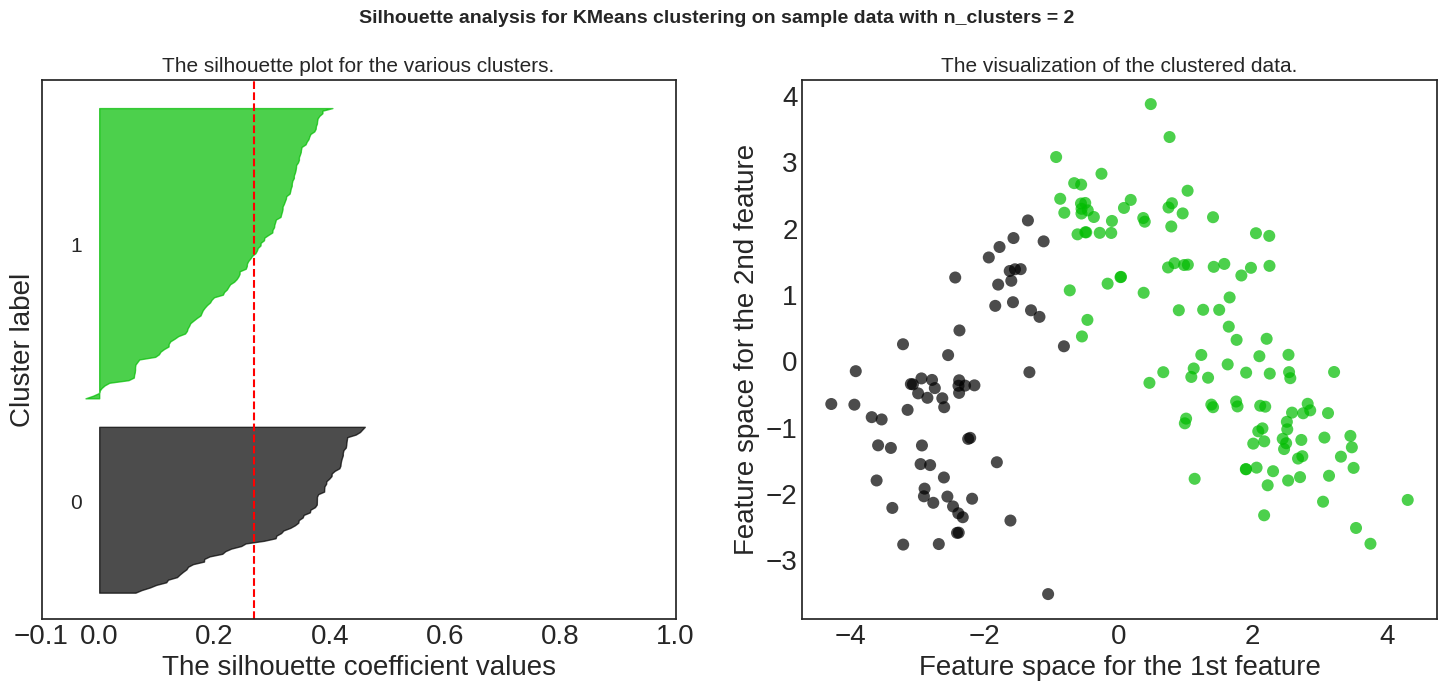

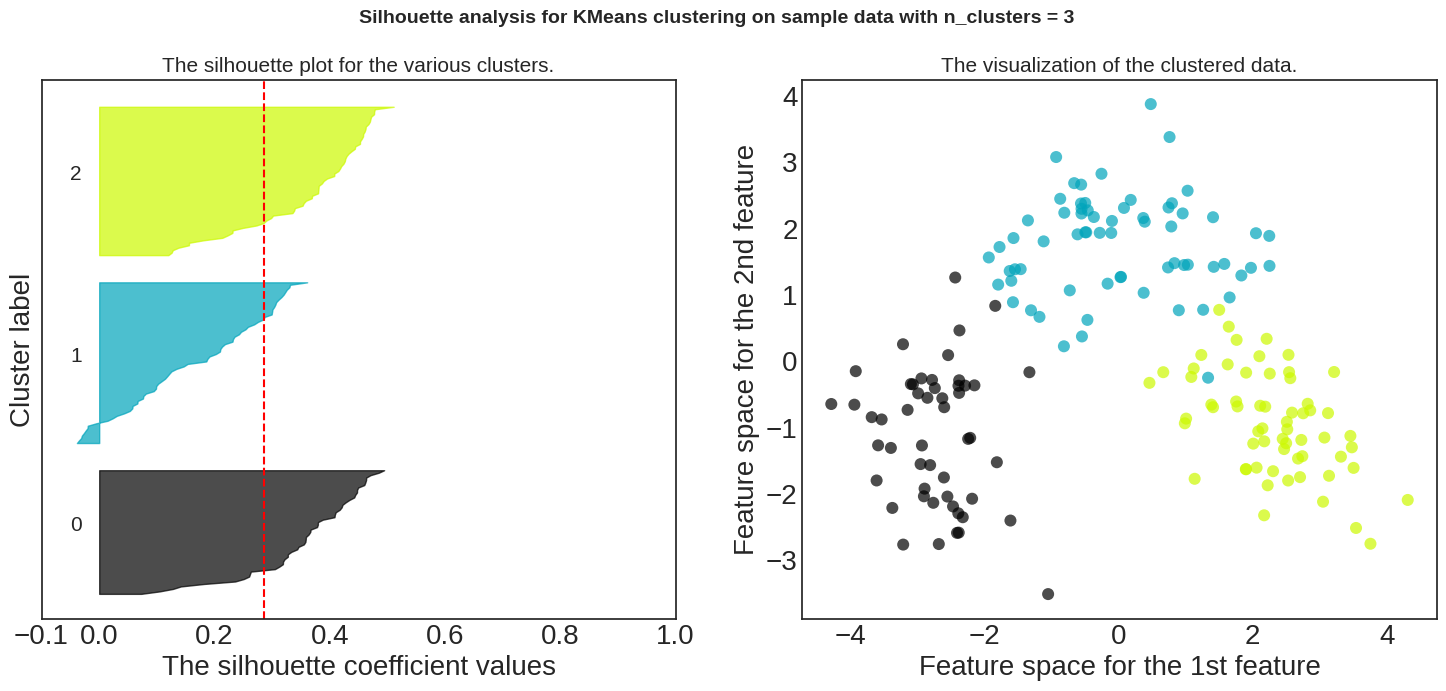

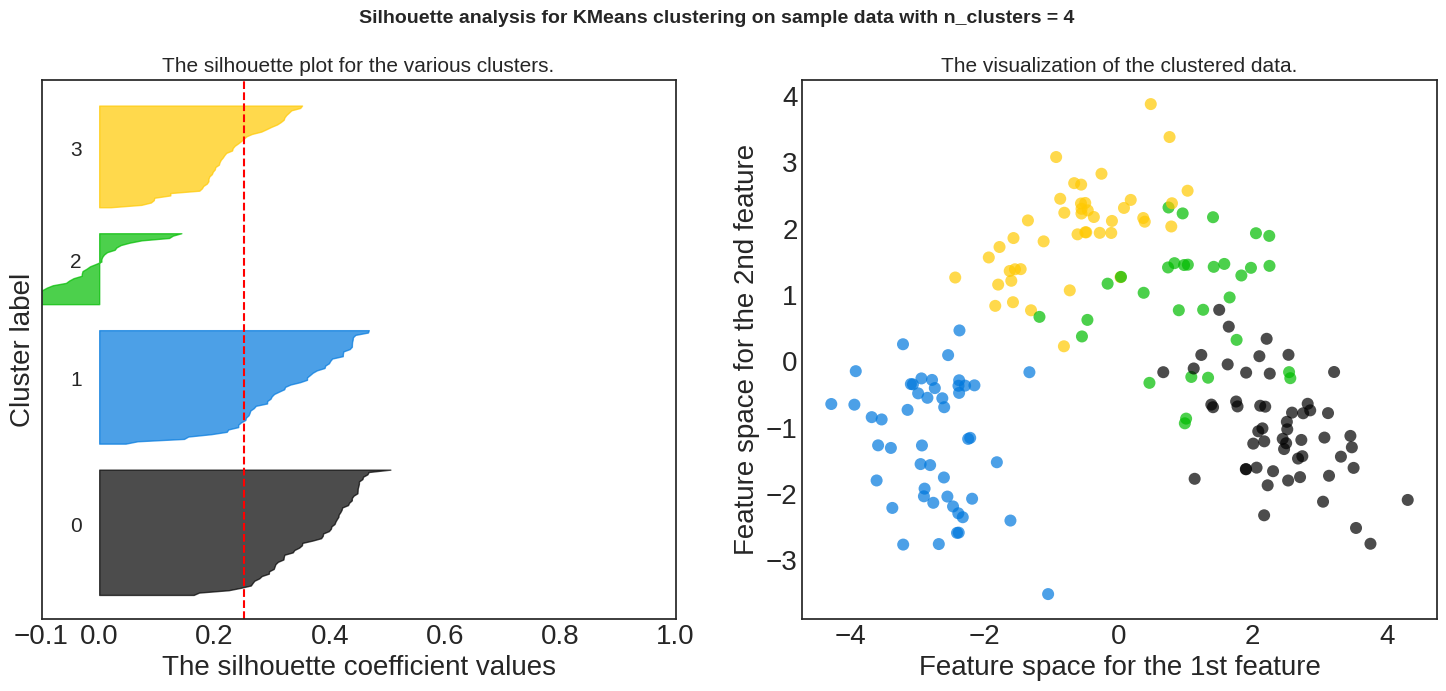

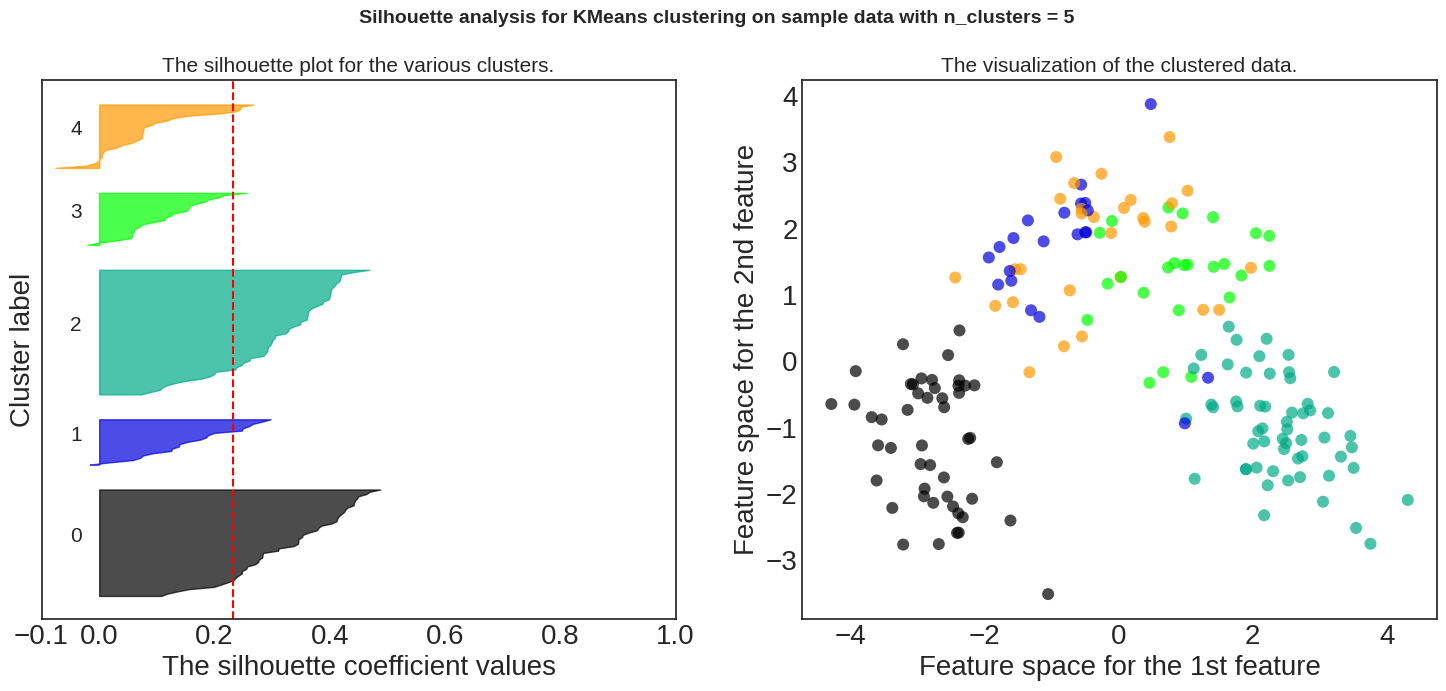

In [393]:
plot_silhoette(model=KMeans,
               X=X_scaled,
               X_2d=X_2d,
               max_num_clusters=6)

By mean silhouette score optimal count of clusters is 3.


## Inertia method
For K-Means we can also use elbow method based on inertia of fitted K-Means model. <p>
Elbow rule is rule for selecting optimal points of monotonic curves. Basic principle is to find the point  where increasing argument doesn't give significal gain. Mathematically we can detect it with finding maximum of second derivative. <p>

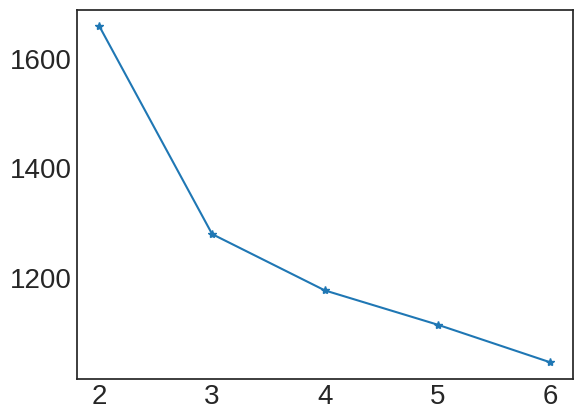

In [394]:
inertias = []
n_clust_grid = [i for i in range(2, 7)]
for n_clusters in n_clust_grid:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)

plt.plot(n_clust_grid, inertias, marker="*")
plt.show()

For this example elbow rule gives the same result as silhoette score - 3 clusters. Important point that for 1 - 2 clusters this method is not so applicable as we cannot estimate second derivative. <p>
Some information about automization of elbow rule <p>

https://www.datasciencecentral.com/profiles/blogs/how-to-automatically-determine-the-number-of-clusters-in-your-dat <p>
https://raghavan.usc.edu//papers/kneedle-simplex11.pdf

# Conclusion


In this workshop:

1.   We studied and tested four basic clustering models: K-means, GMM, agglomerative clustering and DBSCAN.
2.   We used internal and external quality metrics to compare different models.
3. We tested several approaches to selecting optimal number of clusters.

